# Alkım Ege Akarsu | 21901461 | GE 461 | Project 3: Supervised Learning

## Import Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from copy import deepcopy

np.random.seed(0)

## Functions

In [2]:
def load_dataset():
    """Load training and test sets from text files.

    Returns:
        ndarray: Training set.
        ndarray: Test set.
    """
    # Get dataset paths
    train_set_path = Path().resolve().joinpath("train1.txt")
    test_set_path = Path().resolve().joinpath("test1.txt")
    # Load train and test sets
    train_set = np.loadtxt(train_set_path, delimiter="\t")
    test_set = np.loadtxt(test_set_path, delimiter="\t")
    
    return train_set, test_set


def scale_data(X_train, y_train, X_test, y_test):
    """Scale data into [0, 1].

    Args:
        X_train (ndarray): Feature values of training set.
        y_train (ndarray): Target values of training set.
        X_test (ndarray): Feature values of test set.
        y_test (ndarray): Target values of test set.

    Returns:
        ndarray: Scaled training set X.
        ndarray: Scaled training set y.
        ndarray: Scaled test set X.
        ndarray: Scaled test set y.
    """
    # Get min and max values of training X and y
    X_min, X_max = np.min(X_train), np.max(X_train)
    y_min, y_max = np.min(y_train), np.max(y_train)
    # Scale the training and test data
    X_train_scaled = (X_train - X_min) / (X_max - X_min)
    y_train_scaled = (y_train - y_min) / (y_max - y_min)
    X_test_scaled = (X_test - X_min) / (X_max - X_min)
    y_test_scaled = (y_test - y_min) / (y_max - y_min)

    return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled


def descale_data(y_pred, y_train):
    """Descale data back to original values.

    Args:
        y_pred (ndarray): Predicted target values.
        y_train (ndarray): True target values.

    Returns:
        ndarray: Descaled predicted target values.
    """
    # Get min and max values of training y
    y_min, y_max = np.min(y_train), np.max(y_train)
    # Descale the predicted y
    y_pred_descaled = y_pred * (y_max - y_min) + y_min
    
    return y_pred_descaled


def get_X_y(set):
    """Get X and y vectors from training or test set read from the text files.

    Args:
        set (ndarray): _description_

    Returns:
        ndarray: X vector.
        ndarray: y vector.
    """
    # Get X (first column) 
    X = set[:, 0].reshape(-1, 1)
    # Get y (second column)
    y = set[:, 1].reshape(-1, 1)
    
    return X, y


def sigmoid(x):
    """The sigmoid function.

    Args:
        x (ndarray): Array of inputs.

    Returns:
        ndarray: Output of the sigmoid function.
    """
    return 1 / (1 + np.exp(-x))


def get_loss(y_pred, y_true):
    """Sum of squared errors loss function.

    Args:
        current_values (ndarray): Output of the network.
        y (ndarray): Target values.
    
    Returns:
        float: Loss value.
    """
    return np.sum((y_pred - y_true) ** 2)


def get_loss_ave_std(y_pred, y_true):
    """Average and standard deviation of squared errors loss function.

    Args:
        y_pred (ndarray): Predicted target values.
        y_true (ndarray): True target values.
    
    Returns:
        float: Average loss value.
        float: Standard deviation of loss values.
    """
    # Get squared errors for each data point
    losses = (y_pred - y_true) ** 2
    # Get average loss
    loss_ave = np.mean(losses)
    # Get standard deviation of loss
    loss_std = np.std(losses)
    
    return loss_ave, loss_std


def init_W_b(layer_dimensions):
    """Initialize the weights and biases of each layer.
    Weights are initialized with Xavier weight initialization.
    Biases are initialized with zeros.

    Args:
        layer_dimensions (list): List of dimension of each layer.
    
    Returns:
        dict: Dictionary of weights and biases.
    """
    # Prepare weights and biases storage
    W_b = {}
    # Get number of layers
    num_layers = len(layer_dimensions)
    # Initialize weights and biases
    for layer_index in range(1, num_layers):
        # Xavier weight initialization
        W_b["W" + str(layer_index)] = np.random.uniform(-(1 / np.sqrt(layer_dimensions[layer_index - 1])), (1 / np.sqrt(layer_dimensions[layer_index - 1])), (layer_dimensions[layer_index], layer_dimensions[layer_index - 1]))
        # Zero bias initialization
        W_b["b" + str(layer_index)] = np.zeros((layer_dimensions[layer_index], 1))
    
    return W_b


def forward_pass(X, W_b, layer_dimensions):
    """Forward pass through the whole network.

    Args:
        X (ndarray): Input feature values.
        W_b (dict): Weights and biases of each layer.
    
    Returns:
        ndarray: Output of the network.
        list: List of storages for each layer.
    """
    # Prepare storage of storages
    storages = []
    # Prepare storage for values between layers
    current_values = X
    # Get number of layers
    num_layers = len(layer_dimensions)
    # Loop over layers and calculate results
    for layer_index in range(1, num_layers):
        # Store previous values for calculations
        prev_values = current_values
        # Linear part (result = w*x + b)
        linear_result = np.dot(W_b["W" + str(layer_index)], prev_values) + W_b["b" + str(layer_index)]
        # Linear part storage for backpropagation
        linear_storage = (prev_values, W_b["W" + str(layer_index)], W_b["b" + str(layer_index)])
        # If not the last layer, apply sigmoid
        if layer_index != (num_layers - 1):
            current_values = sigmoid(linear_result)
        # For the last layer, use identity function
        else:
            current_values = linear_result
        # Add linear_storage and activation values to storage
        storage = (linear_storage, linear_result)
        # Append current layer storages to the storages list
        storages.append(storage)  # This list is used for backpropagation
    
    return current_values, storages


def one_layer_backprop(current_values_derivative, storage, activation_type):
    """Backpropagation through one layer.
    Assemble many of these for full backpropagation.

    Args:
        current_values_derivative (ndarray): Derivative of the current values.
        storage (list): Storage from the forward pass.

    Returns:
        ndarray: Derivative of the previous values.
        ndarray: Derivative of the weights.
        ndarray: Derivative of the biases.
    """
    # Unpack linear_storage, linear_result from storage
    linear_storage, linear_result = storage
    # Get derivative of linear_result
    if activation_type == "sigmoid":
        linear_result_derivative = current_values_derivative * sigmoid(linear_result) * (1 - sigmoid(linear_result))
    elif activation_type == "linear":
        linear_result_derivative = current_values_derivative
    else:
        raise ValueError("one_layer_backprop function ERROR: Invalid activation_type. Expected 'sigmoid' or 'linear'.")
    # Unpack prev_values, W, b from linear_storage
    prev_values, W, b = linear_storage
    # Get derivative of W
    dW = np.dot(linear_result_derivative, prev_values.T)
    # Get derivative of b
    db = np.sum(linear_result_derivative, axis=1, keepdims=True)
    # Get derivative of prev_values
    prev_values_derivative = np.dot(W.T, linear_result_derivative)
    
    return prev_values_derivative, dW, db


def backprop(final_values, y, storages, layer_dimensions):
    """Backpropagation through the whole network.

    Args:
        final_values (ndarray): Output of the network.
        y (ndarray): Desired output.
        storages (list): List of storages for each layer.
        layer_dimensions (list): List of dimension of each layer.

    Returns:
        dict: Dictionary of gradients.
    """
    # Get number of layers
    num_layers = len(layer_dimensions)
    # Prepare storage for gradients
    gradients = {}
    # Get derivative of final_values
    current_values_derivative = 2 * (final_values - y)
    # Loop over layers in reverse order and calculate gradients
    for layer_index in reversed(range(1, num_layers)):
        # If not the last layer, activation_type is "sigmoid"
        if layer_index != (num_layers - 1):
            activation_type = "sigmoid"
        # For the last layer, activation_type is "linear"
        else:
            activation_type = "linear"
        # Call one_layer_backprop function to get gradients
        prev_values_derivative, dW, db = one_layer_backprop(current_values_derivative, storages[layer_index - 1], activation_type)
        # Store gradients
        gradients["dW" + str(layer_index)] = dW
        gradients["db" + str(layer_index)] = db
        # Update current_values_derivative for the next layer
        current_values_derivative = prev_values_derivative
    
    return gradients


def update_W_b(W_b, gradients, learning_rate, layer_dimensions):
    """Update the weights and biases of each layer.

    Args:
        W_b (dict): Dictionary of weights and biases.
        gradients (dict): Dictionary of gradients.
        learning_rate (float): Learning rate.
        layer_dimensions (list): List of dimension of each layer.

    Returns:
        dict: Dictionary of updated weights and biases.
    """
    # Get number of layers
    num_layers = len(layer_dimensions)
    # Loop over layers
    for layer_index in range(1, num_layers):
        # Update W and b
        W_b["W" + str(layer_index)] = W_b["W" + str(layer_index)] - learning_rate * gradients["dW" + str(layer_index)]
        W_b["b" + str(layer_index)] = W_b["b" + str(layer_index)] - learning_rate * gradients["db" + str(layer_index)]
        
    return W_b


def train(X, y, layer_dimensions, epochs, learning_rate, verbose=False):
    """Train the network using stochastic gradient descent.

    Args:
        X (ndarray): Input feature values.
        y (ndarray): True target values.
        layer_dimensions (list): List of dimension of each layer.
        epochs (int): Number of epochs.
        learning_rate (float): Learning rate.

    Returns:
        dict: Dictionary of updated weights and biases.
        list: List of loss values for each epoch.
    """
    # Copy X and y
    X = X.copy()
    y = y.copy()
    # Take transpose of X and y
    X = X.T
    y = y.T
    # Initialize weights and biases
    W_b = init_W_b(layer_dimensions)
    # Prepare storage for loss values
    losses = []
    # Loop over epochs
    for i in range(epochs):
        # Loop over individual training examples
        for j in range(X.shape[1]):
            # Forward pass for the current example
            y_pred, storages = forward_pass(X[:, j:j+1], W_b, layer_dimensions)
            # Backprop for the current example
            gradients = backprop(y_pred, y[:, j:j+1], storages, layer_dimensions)
            # Update weights and biases for the current example
            W_b = update_W_b(W_b, gradients, learning_rate, layer_dimensions)
        # Forward pass for loss calculation
        y_pred, _ = forward_pass(X, W_b, layer_dimensions)
        # Store loss
        losses.append(get_loss(y_pred, y))
        # # Forward pass
        # y_pred, storages = forward_pass(X, W_b, layer_dimensions)
        # # Store loss
        # losses.append(get_loss(y_pred, y))
        # # Backprop
        # gradients = backprop(y_pred, y, storages, layer_dimensions)
        # # Update weights and biases
        # W_b = update_W_b(W_b, gradients, learning_rate, layer_dimensions)
    # Plot losses if verbose
    if verbose == True:
        plot_training_loss(losses, layer_dimensions, epochs, learning_rate)
        print(f"Final loss: {losses[-1]}")
    
    return W_b, losses


def predict(X, W_b, layer_dimensions):
    """Predict the target values using the trained network.

    Args:
        X (ndarray): Input feature values.
        W_b (dict): Weights and biases of each layer.
        layer_dimensions (list): List of dimension of each layer.

    Returns:
        ndarray: Predicted target values.
    """
    # Copy X
    X = X.copy()
    # Take transpose of X
    X = X.T
    
    return forward_pass(X, W_b, layer_dimensions)[0]


def modify_W_b_single_hidden_unit(W_b, layer_dimensions, hidden_unit_index_to_keep):
    """Delete all hidden units except the one we want to keep.

    Args:
        W_b (dict): Weights and biases of each layer.
        layer_dimensions (list): List of dimension of each layer.
        hidden_unit_index_to_keep (int): Index of the hidden unit we want to keep.

    Returns:
        dict: Modified weights and biases.
    """
    # Copy W_b
    W_b_result = deepcopy(W_b)
    # Loop over W2 list
    for weight_index in range(layer_dimensions[1]):
        if weight_index != hidden_unit_index_to_keep:
            W_b_result["W2"][0][weight_index] = 0

    return W_b_result


def plot_training_loss(losses, layer_dimensions, epochs, learning_rate):
    """Plot the training loss.

    Args:
        losses (list): List of loss values for each epoch.
    """
    plt.figure()
    plt.suptitle("Training Loss", fontsize=16, weight="bold")
    plt.title(f"Layer Dimensions: {layer_dimensions}, Number of Epochs: {epochs}, Learning Rate: {learning_rate}",
              fontsize=10)
    plt.xlabel("Epoch")
    plt.ylabel("Sum of Squared Errors")
    plt.plot(losses)
    plt.show()


def plot_train_test(X_train, y_train, X_test, y_test):
    """Plot training and test sets.

    Args:
        X_train (ndarray): Feature values of training set.
        y_train (ndarray): Target values of training set.
        X_test (ndarray): Feature values of test set.
        y_test (ndarray): Target values of test set.
    """
    plt.figure()
    plt.title("Training and Test Sets")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.scatter(X_train, y_train, label="Training", alpha=0.5)
    plt.scatter(X_test, y_test, label="Test", alpha=0.5)
    plt.legend()
    plt.show()


def plot_pred_true(X_true, y_true, y_pred):
    """Plot the predicted and true values.

    Args:
        X_true (ndarray): Input feature values.
        y_true (ndarray): True target values.
        y_pred (ndarray): Predicted target values.
    """
    plt.figure()
    plt.title("Truth vs Prediction")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.scatter(X_true, y_true, label="Truth", alpha=0.5)
    plt.scatter(X_true, y_pred, label="Predicted", alpha=0.5)
    plt.legend()
    plt.show()


def plot_pred_true_curve(X_true, y_true, X_curve, y_curve):
    """Plot the predicted and true values and the prediction curve.

    Args:
        X_true (ndarray): Input feature values.
        y_true (ndarray): True target values.
        y_pred (ndarray): Predicted target values.
        X_curve (ndarray): X values of prediction curve.
        y_curve (ndarray): y values of prediction curve.
    """
    plt.figure()
    plt.title("Truth vs Prediction")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.scatter(X_true, y_true, label="Truth", alpha=0.5)
    plt.plot(X_curve, y_curve.T, "r", label="Prediction Curve", linewidth=2)
    plt.legend()
    plt.show()

## Main Code

### Working with the dataset

The shape of the training set is : (60, 2).
The shape of the test set is : (41, 2).



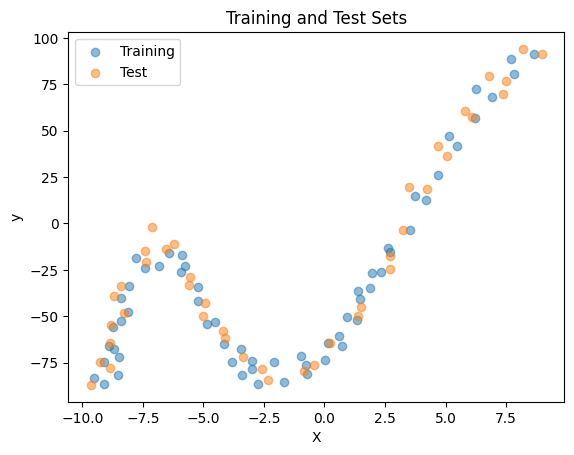

In [3]:
# Load dataset
train_set, test_set = load_dataset()
print(f"The shape of the training set is : {train_set.shape}.")
print(f"The shape of the test set is : {test_set.shape}.\n")
# Get X and y from training and test sets
X_train, y_train = get_X_y(train_set)
X_test, y_test = get_X_y(test_set)
# Plot data
plot_train_test(X_train, y_train, X_test, y_test)
# Scale data into [0, 1]
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = scale_data(X_train, y_train, X_test, y_test)

### (a)

#### Linear Model Experimentation

In [4]:
# #LAYERS: [1, 1], SCALED
# # Define layer dimensions
# layer_dimensions = [1, 1]
# # Train the network
# W_b, losses = train(X_train_scaled, y_train_scaled, layer_dimensions, 600, 0.001, verbose=True)
# # Get predicted target values
# y_pred = predict(X_test_scaled, W_b, layer_dimensions)
# # Plot truth vs predicted
# plot_pred_true(X_test_scaled, y_test_scaled, y_pred)

# # LAYERS: [1, 1], NONSCALED
# # Define layer dimensions
# layer_dimensions = [1, 1]
# # Train the network
# W_b, losses = train(X_train, y_train, layer_dimensions, 600, 0.0001, verbose=True)
# # Get predicted target values
# y_pred = predict(X_test, W_b, layer_dimensions)
# # Plot truth vs predicted
# plot_pred_true(X_test, y_test, y_pred)

#### Nonlinear Model Experimentation

In [5]:
# # LAYERS: [1, 1, 1], SCALED
# # Define layer dimensions
# layer_dimensions = [1, 1, 1]
# # Train the network
# W_b, losses = train(X_train_scaled, y_train_scaled, layer_dimensions, 10000, 0.1, verbose=True)
# # Get predicted target values
# y_pred = predict(X_test_scaled, W_b, layer_dimensions)
# # Plot truth vs predicted
# plot_pred_true(X_test_scaled, y_test_scaled, y_pred)

# # LAYERS: [1, 1, 1], NONSCALED
# # Define layer dimensions
# layer_dimensions = [1, 1, 1]
# # Train the network
# W_b, losses = train(X_train, y_train, layer_dimensions, 10000, 0.00005, verbose=True)
# # Get predicted target values
# y_pred = predict(X_test, W_b, layer_dimensions)
# # Plot truth vs predicted
# plot_pred_true(X_test, y_test, y_pred)

# # LAYERS: [1, 2, 1], SCALED
# # Define layer dimensions
# layer_dimensions = [1, 2, 1]
# # Train the network
# W_b, losses = train(X_train_scaled, y_train_scaled, layer_dimensions, 100000, 0.001, verbose=True)
# # Get predicted target values
# y_pred = predict(X_test_scaled, W_b, layer_dimensions)
# # Plot truth vs predicted
# plot_pred_true(X_test_scaled, y_test_scaled, y_pred)

# # LAYERS: [1, 3, 1], SCALED -------------------------------------------------------------------------------------------------------------------
# # Define layer dimensions
# layer_dimensions = [1, 3, 1]
# # Train the network
# W_b, losses = train(X_train_scaled, y_train_scaled, layer_dimensions, 100, 0.01, verbose=True)
# # Get predicted target values
# y_pred = predict(X_test_scaled, W_b, layer_dimensions)
# # Plot truth vs predicted
# plot_pred_true(X_test_scaled, y_test_scaled, y_pred)

# # LAYERS: [1, 4, 1], SCALED
# # Define layer dimensions
# layer_dimensions = [1, 4, 1]
# # Train the network
# W_b, losses = train(X_train_scaled, y_train_scaled, layer_dimensions, 70000, 0.01, verbose=True)
# # Get predicted target values
# y_pred = predict(X_test_scaled, W_b, layer_dimensions)
# # Plot truth vs predicted
# plot_pred_true(X_test_scaled, y_test_scaled, y_pred)

# # LAYERS: [1, 5, 1], SCALED
# # Define layer dimensions
# layer_dimensions = [1, 5, 1]
# # Train the network
# W_b, losses = train(X_train_scaled, y_train_scaled, layer_dimensions, 70000, 0.01, verbose=True)
# # Get predicted target values
# y_pred = predict(X_test_scaled, W_b, layer_dimensions)
# # Plot truth vs predicted
# plot_pred_true(X_test_scaled, y_test_scaled, y_pred)

### (b)

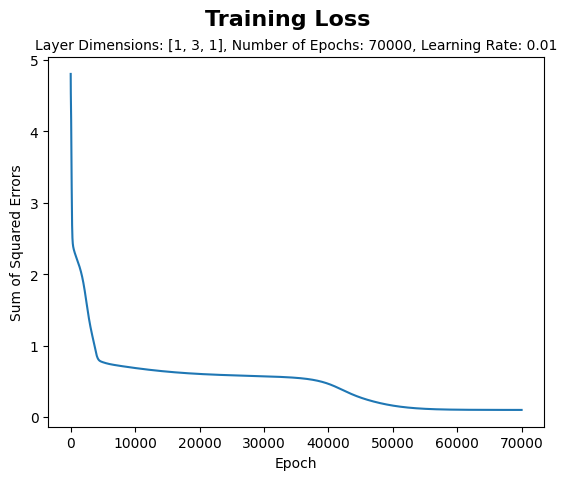

Final loss: 0.09950265357807962


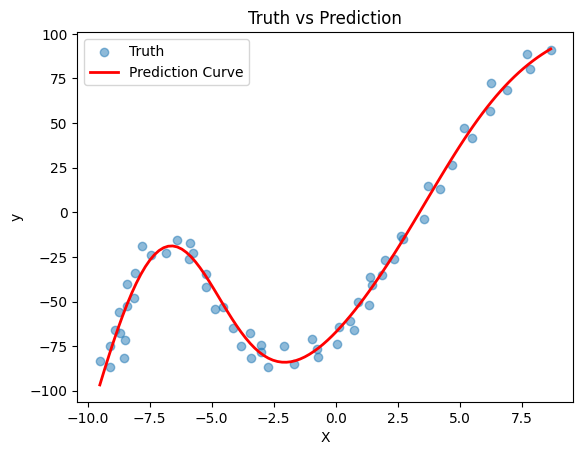

Total training loss: 3135.6001006032984
Training loss averaged over all training instances: 52.26000167672164


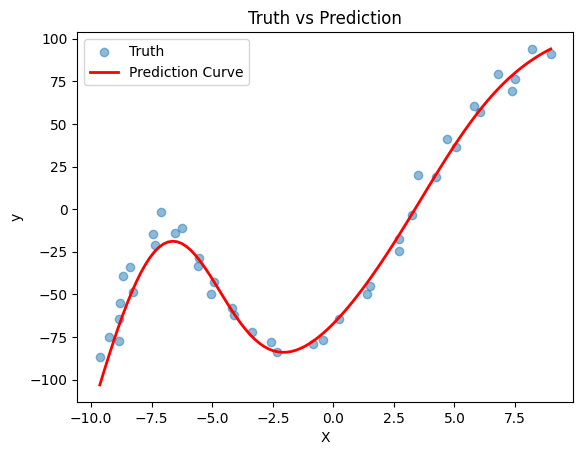

Total test loss: 3051.8944905714825
Test loss averaged over all test instances: 74.43645098954835


In [6]:
# LAYERS: [1, 3, 1], SCALED
# Define layer dimensions
layer_dimensions = [1, 3, 1]
# Train the network
W_b, losses = train(X_train_scaled, y_train_scaled, layer_dimensions, 70000, 0.01, verbose=True)

# Training set plot
# Get predicted target values
y_pred = predict(X_train_scaled, W_b, layer_dimensions)
# Descale predicted target values
y_pred = descale_data(y_pred, y_train)
# Get prediction curve points
X_curve_points = np.linspace(X_train_scaled.min(), X_train_scaled.max(), 100).reshape(-1, 1)
# Get predicted curve points
y_curve_points = predict(X_curve_points, W_b, layer_dimensions)
# Descale prediction curve points
X_curve_points = descale_data(X_curve_points, X_train)
# Descale predicted curve points
y_curve_points = descale_data(y_curve_points, y_train)
# Plot the curve
plot_pred_true_curve(X_train, y_train, X_curve_points, y_curve_points)
# Get training loss averaged over all training instances
loss = get_loss(y_pred, y_train.T)
ave_loss = loss / X_train.shape[0]
print(f"Total training loss: {loss}")
print(f"Training loss averaged over all training instances: {ave_loss}")

# Test set plot
# Get predicted target values
y_pred = predict(X_test_scaled, W_b, layer_dimensions)
# Descale predicted target values
y_pred = descale_data(y_pred, y_train)
# Get prediction curve points
X_curve_points = np.linspace(X_test_scaled.min(), X_test_scaled.max(), 100).reshape(-1, 1)
# Get predicted curve points
y_curve_points = predict(X_curve_points, W_b, layer_dimensions)
# Descale prediction curve points
X_curve_points = descale_data(X_curve_points, X_train)
# Descale predicted curve points
y_curve_points = descale_data(y_curve_points, y_train)
# Plot the curve
plot_pred_true_curve(X_test, y_test, X_curve_points, y_curve_points)
# Get test loss averaged over all test instances
loss = get_loss(y_pred, y_test.T)
ave_loss = loss / X_test.shape[0]
print(f"Total test loss: {loss}")
print(f"Test loss averaged over all test instances: {ave_loss}")

### (c)

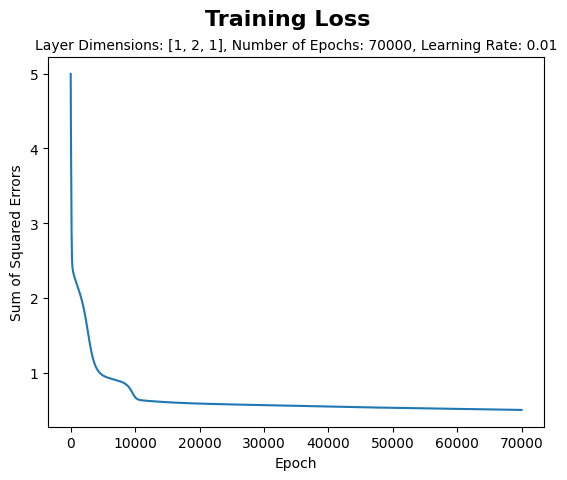

Final loss: 0.5057626116679931
Average of training loss over all training instances (2HUs): 265.63266388721917
Standard deviation of training loss over all training instances (2HUs): 399.08690409484336
Average of training loss over all test instances (2HUs): 338.36161613070715
Standard deviation of training loss over all test instances (2HUs): 561.3491416184645


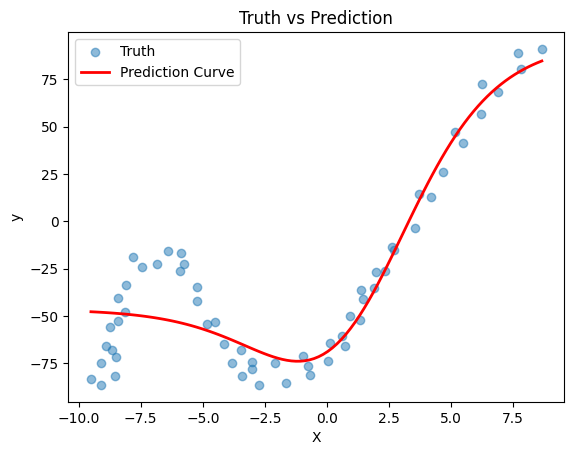

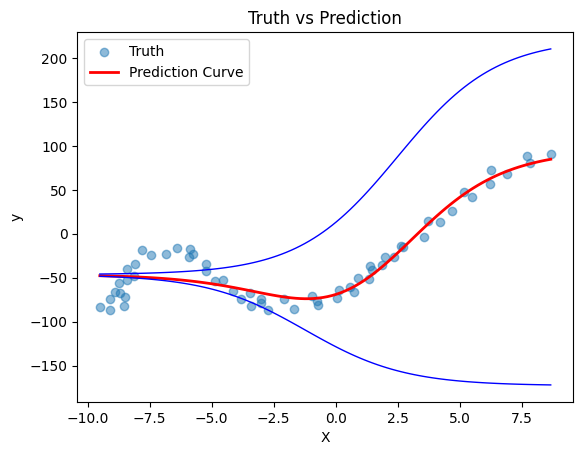

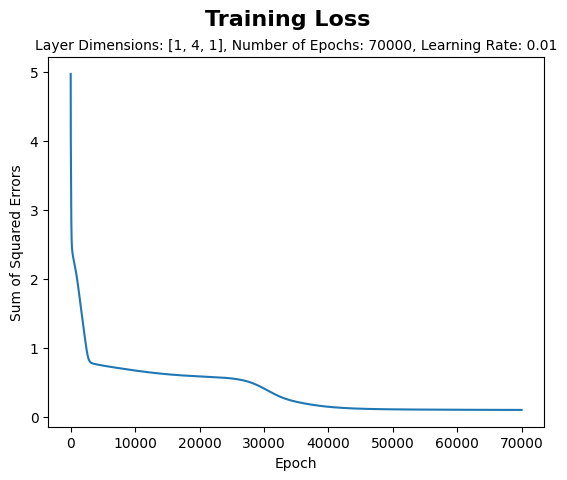

Final loss: 0.10307975033709614
Average of training loss over all training instances (4HUs): 54.13873632249975
Standard deviation of training loss over all training instances (4HUs): 100.05353612055484
Average of training loss over all test instances (4HUs): 76.07408937771687
Standard deviation of training loss over all test instances (4HUs): 112.90111740716632


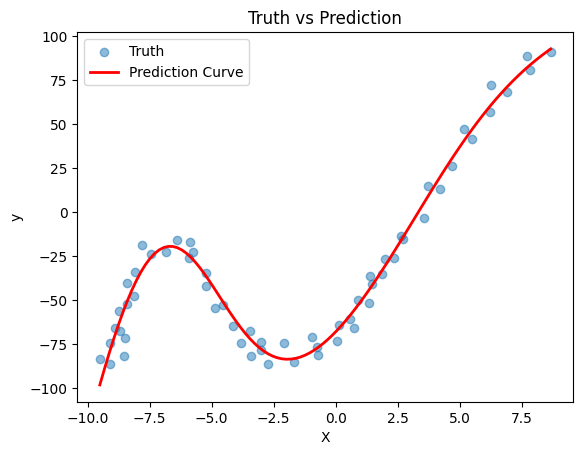

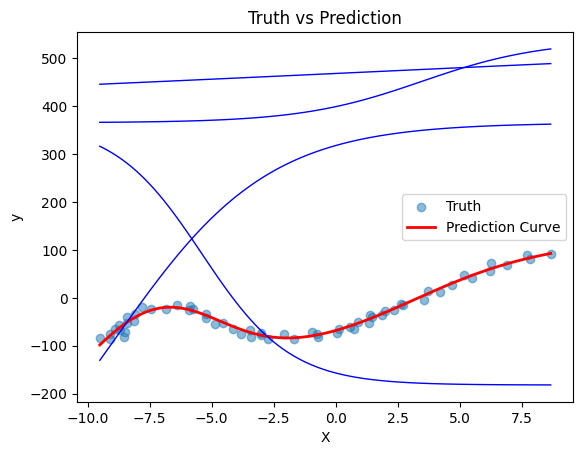

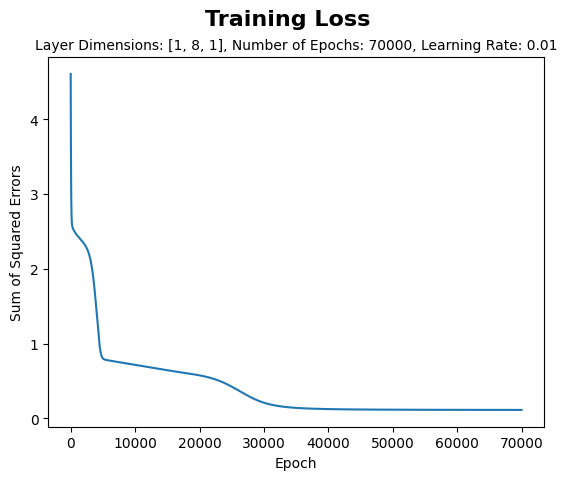

Final loss: 0.11300138914141368
Average of training loss over all training instances (8HUs): 59.349701476736506
Standard deviation of training loss over all training instances (8HUs): 104.0043562072026
Average of training loss over all test instances (8HUs): 83.40969940710201
Standard deviation of training loss over all test instances (8HUs): 109.70060532932897


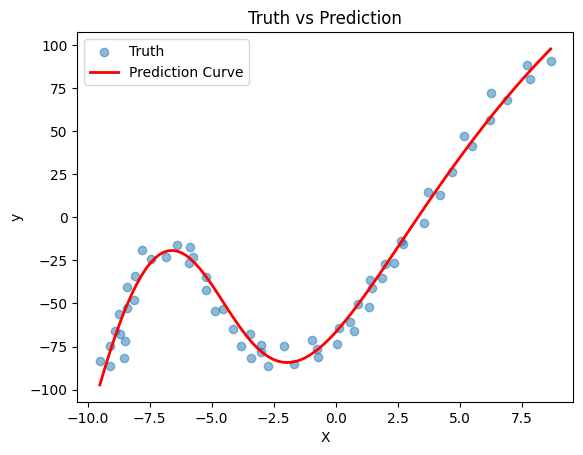

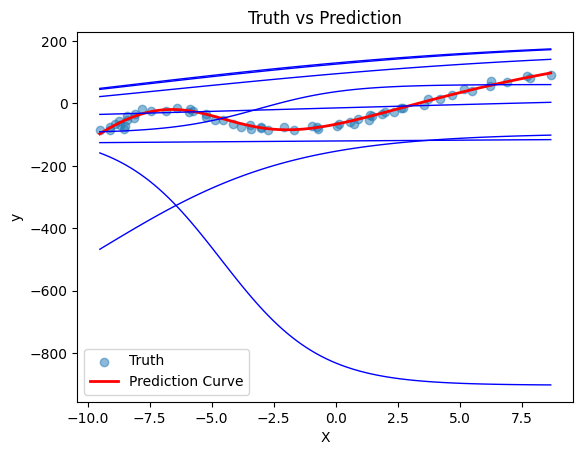

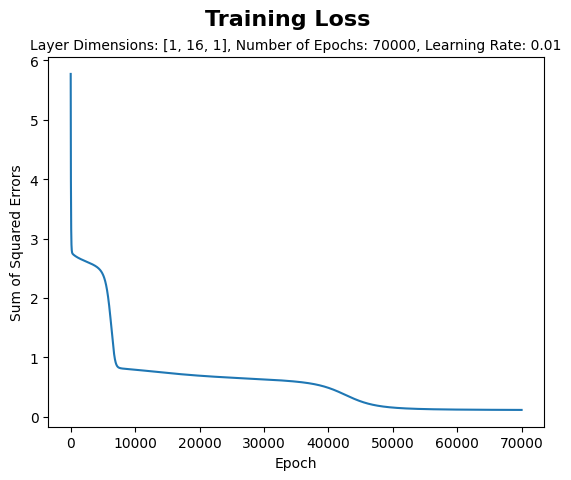

Final loss: 0.11331338492277819
Average of training loss over all training instances (16HUs): 59.51356544891131
Standard deviation of training loss over all training instances (16HUs): 104.21897991237898
Average of training loss over all test instances (16HUs): 86.67177629190552
Standard deviation of training loss over all test instances (16HUs): 114.4722031754083


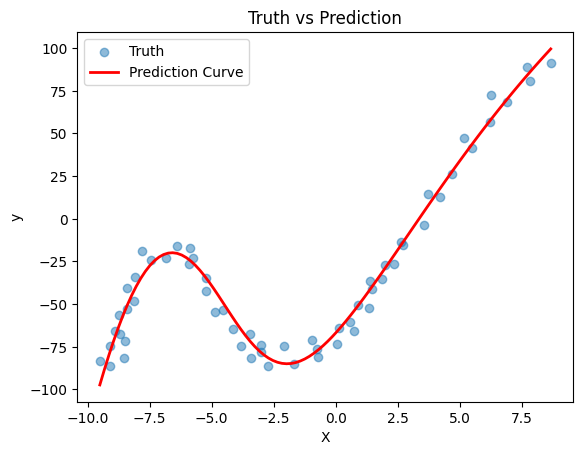

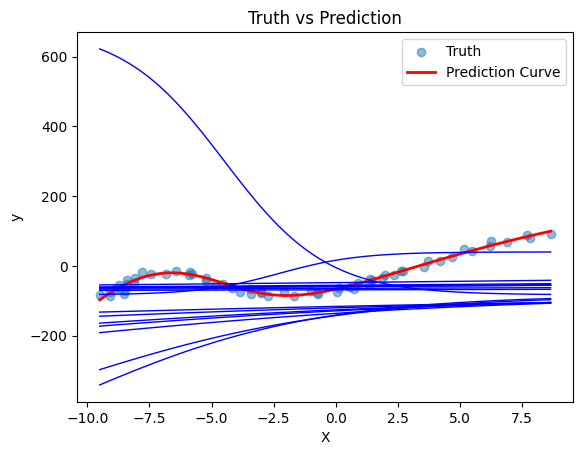

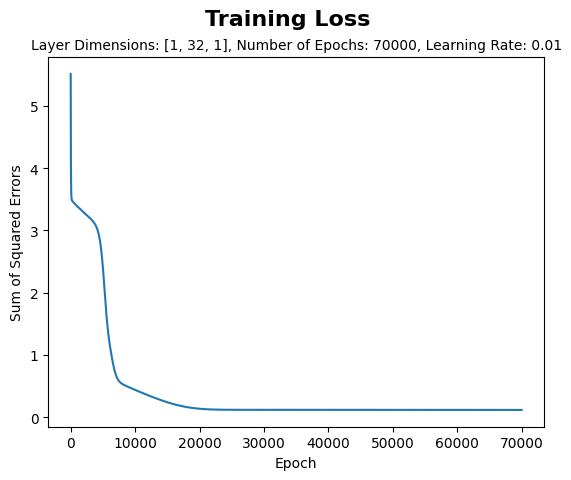

Final loss: 0.11812131233090563
Average of training loss over all training instances (32HUs): 62.03874729457065
Standard deviation of training loss over all training instances (32HUs): 103.81966868996173
Average of training loss over all test instances (32HUs): 82.95361409462629
Standard deviation of training loss over all test instances (32HUs): 105.33602558187302


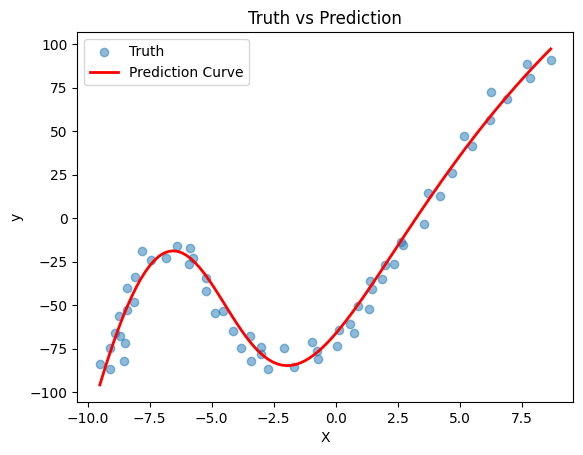

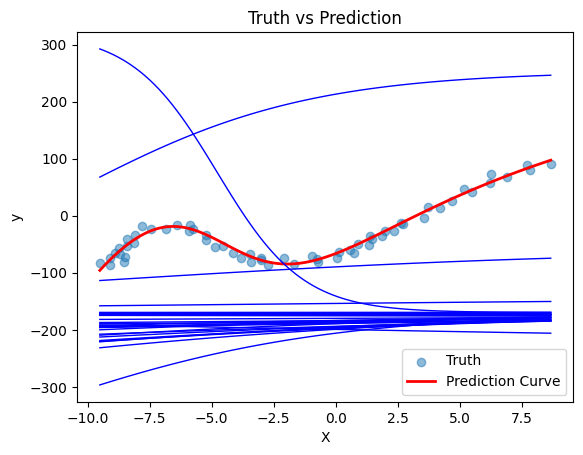

In [7]:
# LAYERS: [1, 2, 1], SCALED
# Define layer dimensions
layer_dimensions = [1, 2, 1]
# Train the network
W_b, losses = train(X_train_scaled, y_train_scaled, layer_dimensions, 70000, 0.01, verbose=True)

# Training set plot
# Get predicted target values
y_pred = predict(X_train_scaled, W_b, layer_dimensions)
# Descale predicted target values
y_pred = descale_data(y_pred, y_train)
# Get prediction curve points
X_curve_points = np.linspace(X_train_scaled.min(), X_train_scaled.max(), 100).reshape(-1, 1)
# Get predicted curve points
y_curve_points = predict(X_curve_points, W_b, layer_dimensions)
# Descale prediction curve points
X_curve_points = descale_data(X_curve_points, X_train)
# Descale predicted curve points
y_curve_points = descale_data(y_curve_points, y_train)

# Get training loss ave and std
ave_loss, std_loss = get_loss_ave_std(y_pred.T, y_train)
print(f"Average of training loss over all training instances ({layer_dimensions[1]}HUs): {ave_loss}")
print(f"Standard deviation of training loss over all training instances ({layer_dimensions[1]}HUs): {std_loss}")
# Get test loss ave and std
# Get predicted target values
y_pred = predict(X_test_scaled, W_b, layer_dimensions)
# Descale predicted target values
y_pred = descale_data(y_pred, y_train)
ave_loss, std_loss = get_loss_ave_std(y_pred.T, y_test)
print(f"Average of training loss over all test instances ({layer_dimensions[1]}HUs): {ave_loss}")
print(f"Standard deviation of training loss over all test instances ({layer_dimensions[1]}HUs): {std_loss}")

# Plot only the prediction curve
plot_pred_true_curve(X_train, y_train, X_curve_points, y_curve_points)

# Plot true outputs and all curves
plt.figure()
plt.title("Truth vs Prediction")
plt.xlabel("X")
plt.ylabel("y")
plt.scatter(X_train, y_train, label="Truth", alpha=0.5)
plt.plot(X_curve_points, y_curve_points.T, "r", label="Prediction Curve", linewidth=2)
# Draw curves for each hidden unit
for weight_index in range(layer_dimensions[1]):
    # Remove all hidden units except the one we want to keep
    temp_W_b = modify_W_b_single_hidden_unit(W_b, layer_dimensions, weight_index)
    # Get prediction curve points
    X_curve_points = np.linspace(X_train_scaled.min(), X_train_scaled.max(), 100).reshape(-1, 1)
    # Get predicted curve points
    y_curve_points = predict(X_curve_points, temp_W_b, layer_dimensions)
    # Descale prediction curve points
    X_curve_points = descale_data(X_curve_points, X_train)
    # Descale predicted curve points
    y_curve_points = descale_data(y_curve_points, y_train)
    # Plot the curve for this hidden unit
    plt.plot(X_curve_points, y_curve_points.T, "b", linewidth=1)
plt.legend()
plt.show()





# LAYERS: [1, 4, 1], SCALED
# Define layer dimensions
layer_dimensions = [1, 4, 1]
# Train the network
W_b, losses = train(X_train_scaled, y_train_scaled, layer_dimensions, 70000, 0.01, verbose=True)

# Training set plot
# Get predicted target values
y_pred = predict(X_train_scaled, W_b, layer_dimensions)
# Descale predicted target values
y_pred = descale_data(y_pred, y_train)
# Get prediction curve points
X_curve_points = np.linspace(X_train_scaled.min(), X_train_scaled.max(), 100).reshape(-1, 1)
# Get predicted curve points
y_curve_points = predict(X_curve_points, W_b, layer_dimensions)
# Descale prediction curve points
X_curve_points = descale_data(X_curve_points, X_train)
# Descale predicted curve points
y_curve_points = descale_data(y_curve_points, y_train)

# Get training loss ave and std
ave_loss, std_loss = get_loss_ave_std(y_pred.T, y_train)
print(f"Average of training loss over all training instances ({layer_dimensions[1]}HUs): {ave_loss}")
print(f"Standard deviation of training loss over all training instances ({layer_dimensions[1]}HUs): {std_loss}")
# Get test loss ave and std
# Get predicted target values
y_pred = predict(X_test_scaled, W_b, layer_dimensions)
# Descale predicted target values
y_pred = descale_data(y_pred, y_train)
ave_loss, std_loss = get_loss_ave_std(y_pred.T, y_test)
print(f"Average of training loss over all test instances ({layer_dimensions[1]}HUs): {ave_loss}")
print(f"Standard deviation of training loss over all test instances ({layer_dimensions[1]}HUs): {std_loss}")

# Plot only the prediction curve
plot_pred_true_curve(X_train, y_train, X_curve_points, y_curve_points)

# Plot true outputs and all curves
plt.figure()
plt.title("Truth vs Prediction")
plt.xlabel("X")
plt.ylabel("y")
plt.scatter(X_train, y_train, label="Truth", alpha=0.5)
plt.plot(X_curve_points, y_curve_points.T, "r", label="Prediction Curve", linewidth=2)
# Draw curves for each hidden unit
for weight_index in range(layer_dimensions[1]):
    # Remove all hidden units except the one we want to keep
    temp_W_b = modify_W_b_single_hidden_unit(W_b, layer_dimensions, weight_index)
    # Get prediction curve points
    X_curve_points = np.linspace(X_train_scaled.min(), X_train_scaled.max(), 100).reshape(-1, 1)
    # Get predicted curve points
    y_curve_points = predict(X_curve_points, temp_W_b, layer_dimensions)
    # Descale prediction curve points
    X_curve_points = descale_data(X_curve_points, X_train)
    # Descale predicted curve points
    y_curve_points = descale_data(y_curve_points, y_train)
    # Plot the curve for this hidden unit
    plt.plot(X_curve_points, y_curve_points.T, "b", linewidth=1)
plt.legend()
plt.show()





# LAYERS: [1, 8, 1], SCALED
# Define layer dimensions
layer_dimensions = [1, 8, 1]
# Train the network
W_b, losses = train(X_train_scaled, y_train_scaled, layer_dimensions, 70000, 0.01, verbose=True)

# Training set plot
# Get predicted target values
y_pred = predict(X_train_scaled, W_b, layer_dimensions)
# Descale predicted target values
y_pred = descale_data(y_pred, y_train)
# Get prediction curve points
X_curve_points = np.linspace(X_train_scaled.min(), X_train_scaled.max(), 100).reshape(-1, 1)
# Get predicted curve points
y_curve_points = predict(X_curve_points, W_b, layer_dimensions)
# Descale prediction curve points
X_curve_points = descale_data(X_curve_points, X_train)
# Descale predicted curve points
y_curve_points = descale_data(y_curve_points, y_train)

# Get training loss ave and std
ave_loss, std_loss = get_loss_ave_std(y_pred.T, y_train)
print(f"Average of training loss over all training instances ({layer_dimensions[1]}HUs): {ave_loss}")
print(f"Standard deviation of training loss over all training instances ({layer_dimensions[1]}HUs): {std_loss}")
# Get test loss ave and std
# Get predicted target values
y_pred = predict(X_test_scaled, W_b, layer_dimensions)
# Descale predicted target values
y_pred = descale_data(y_pred, y_train)
ave_loss, std_loss = get_loss_ave_std(y_pred.T, y_test)
print(f"Average of training loss over all test instances ({layer_dimensions[1]}HUs): {ave_loss}")
print(f"Standard deviation of training loss over all test instances ({layer_dimensions[1]}HUs): {std_loss}")

# Plot only the prediction curve
plot_pred_true_curve(X_train, y_train, X_curve_points, y_curve_points)

# Plot true outputs and all curves
plt.figure()
plt.title("Truth vs Prediction")
plt.xlabel("X")
plt.ylabel("y")
plt.scatter(X_train, y_train, label="Truth", alpha=0.5)
plt.plot(X_curve_points, y_curve_points.T, "r", label="Prediction Curve", linewidth=2)
# Draw curves for each hidden unit
for weight_index in range(layer_dimensions[1]):
    # Remove all hidden units except the one we want to keep
    temp_W_b = modify_W_b_single_hidden_unit(W_b, layer_dimensions, weight_index)
    # Get prediction curve points
    X_curve_points = np.linspace(X_train_scaled.min(), X_train_scaled.max(), 100).reshape(-1, 1)
    # Get predicted curve points
    y_curve_points = predict(X_curve_points, temp_W_b, layer_dimensions)
    # Descale prediction curve points
    X_curve_points = descale_data(X_curve_points, X_train)
    # Descale predicted curve points
    y_curve_points = descale_data(y_curve_points, y_train)
    # Plot the curve for this hidden unit
    plt.plot(X_curve_points, y_curve_points.T, "b", linewidth=1)
plt.legend()
plt.show()





# LAYERS: [1, 16, 1], SCALED
# Define layer dimensions
layer_dimensions = [1, 16, 1]
# Train the network
W_b, losses = train(X_train_scaled, y_train_scaled, layer_dimensions, 70000, 0.01, verbose=True)

# Training set plot
# Get predicted target values
y_pred = predict(X_train_scaled, W_b, layer_dimensions)
# Descale predicted target values
y_pred = descale_data(y_pred, y_train)
# Get prediction curve points
X_curve_points = np.linspace(X_train_scaled.min(), X_train_scaled.max(), 100).reshape(-1, 1)
# Get predicted curve points
y_curve_points = predict(X_curve_points, W_b, layer_dimensions)
# Descale prediction curve points
X_curve_points = descale_data(X_curve_points, X_train)
# Descale predicted curve points
y_curve_points = descale_data(y_curve_points, y_train)

# Get training loss ave and std
ave_loss, std_loss = get_loss_ave_std(y_pred.T, y_train)
print(f"Average of training loss over all training instances ({layer_dimensions[1]}HUs): {ave_loss}")
print(f"Standard deviation of training loss over all training instances ({layer_dimensions[1]}HUs): {std_loss}")
# Get test loss ave and std
# Get predicted target values
y_pred = predict(X_test_scaled, W_b, layer_dimensions)
# Descale predicted target values
y_pred = descale_data(y_pred, y_train)
ave_loss, std_loss = get_loss_ave_std(y_pred.T, y_test)
print(f"Average of training loss over all test instances ({layer_dimensions[1]}HUs): {ave_loss}")
print(f"Standard deviation of training loss over all test instances ({layer_dimensions[1]}HUs): {std_loss}")

# Plot only the prediction curve
plot_pred_true_curve(X_train, y_train, X_curve_points, y_curve_points)

# Plot true outputs and all curves
plt.figure()
plt.title("Truth vs Prediction")
plt.xlabel("X")
plt.ylabel("y")
plt.scatter(X_train, y_train, label="Truth", alpha=0.5)
plt.plot(X_curve_points, y_curve_points.T, "r", label="Prediction Curve", linewidth=2)
# Draw curves for each hidden unit
for weight_index in range(layer_dimensions[1]):
    # Remove all hidden units except the one we want to keep
    temp_W_b = modify_W_b_single_hidden_unit(W_b, layer_dimensions, weight_index)
    # Get prediction curve points
    X_curve_points = np.linspace(X_train_scaled.min(), X_train_scaled.max(), 100).reshape(-1, 1)
    # Get predicted curve points
    y_curve_points = predict(X_curve_points, temp_W_b, layer_dimensions)
    # Descale prediction curve points
    X_curve_points = descale_data(X_curve_points, X_train)
    # Descale predicted curve points
    y_curve_points = descale_data(y_curve_points, y_train)
    # Plot the curve for this hidden unit
    plt.plot(X_curve_points, y_curve_points.T, "b", linewidth=1)
plt.legend()
plt.show()





# LAYERS: [1, 32, 1], SCALED
# Define layer dimensions
layer_dimensions = [1, 32, 1]
# Train the network
W_b, losses = train(X_train_scaled, y_train_scaled, layer_dimensions, 70000, 0.01, verbose=True)

# Training set plot
# Get predicted target values
y_pred = predict(X_train_scaled, W_b, layer_dimensions)
# Descale predicted target values
y_pred = descale_data(y_pred, y_train)
# Get prediction curve points
X_curve_points = np.linspace(X_train_scaled.min(), X_train_scaled.max(), 100).reshape(-1, 1)
# Get predicted curve points
y_curve_points = predict(X_curve_points, W_b, layer_dimensions)
# Descale prediction curve points
X_curve_points = descale_data(X_curve_points, X_train)
# Descale predicted curve points
y_curve_points = descale_data(y_curve_points, y_train)

# Get training loss ave and std
ave_loss, std_loss = get_loss_ave_std(y_pred.T, y_train)
print(f"Average of training loss over all training instances ({layer_dimensions[1]}HUs): {ave_loss}")
print(f"Standard deviation of training loss over all training instances ({layer_dimensions[1]}HUs): {std_loss}")
# Get test loss ave and std
# Get predicted target values
y_pred = predict(X_test_scaled, W_b, layer_dimensions)
# Descale predicted target values
y_pred = descale_data(y_pred, y_train)
ave_loss, std_loss = get_loss_ave_std(y_pred.T, y_test)
print(f"Average of training loss over all test instances ({layer_dimensions[1]}HUs): {ave_loss}")
print(f"Standard deviation of training loss over all test instances ({layer_dimensions[1]}HUs): {std_loss}")

# Plot only the prediction curve
plot_pred_true_curve(X_train, y_train, X_curve_points, y_curve_points)

# Plot true outputs and all curves
plt.figure()
plt.title("Truth vs Prediction")
plt.xlabel("X")
plt.ylabel("y")
plt.scatter(X_train, y_train, label="Truth", alpha=0.5)
plt.plot(X_curve_points, y_curve_points.T, "r", label="Prediction Curve", linewidth=2)
# Draw curves for each hidden unit
for weight_index in range(layer_dimensions[1]):
    # Remove all hidden units except the one we want to keep
    temp_W_b = modify_W_b_single_hidden_unit(W_b, layer_dimensions, weight_index)
    # Get prediction curve points
    X_curve_points = np.linspace(X_train_scaled.min(), X_train_scaled.max(), 100).reshape(-1, 1)
    # Get predicted curve points
    y_curve_points = predict(X_curve_points, temp_W_b, layer_dimensions)
    # Descale prediction curve points
    X_curve_points = descale_data(X_curve_points, X_train)
    # Descale predicted curve points
    y_curve_points = descale_data(y_curve_points, y_train)
    # Plot the curve for this hidden unit
    plt.plot(X_curve_points, y_curve_points.T, "b", linewidth=1)
plt.legend()
plt.show()